# Power and Precision Analysis Tools for Surveys

This notebook provides tools and functions for conducting power analysis, calculating sample sizes, and optimizing survey designs.

## 1. Import Required Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, t
import statsmodels.stats.power as power
import seaborn as sns

# Set style for visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# 2. Functions

In [19]:
def confidence_interval_for_proportion(n, p, N, confidence=0.95):
    """
    Calculate the confidence interval for an estimated population proportion.
    
    This function computes the typical achieved confidence interval when you 
    take a sample of size n from a population of size N and observe a proportion p.
    
    Parameters:
    -----------
    n : int
        Sample size
    p : float
        Population proportion (between 0 and 1)
        The true proportion you're trying to estimate
    N : int
        Total population size
    confidence : float, default 0.95
        Confidence level (e.g., 0.95 for 95% CI)
    
    Returns:
    --------
    dict with keys:
        'margin_of_error': Half-width of the CI
        'ci_lower': Lower bound of the confidence interval
        'ci_upper': Upper bound of the confidence interval
        'sample_estimate': The point estimate (which is p itself in this context)
    """
    # Get the z-value for the desired confidence level
    z = norm.ppf((1 + confidence) / 2)
    
    # Calculate the finite population correction factor
    fpc = np.sqrt((N - n) / (N - 1))
    
    # Calculate standard error with finite population correction
    se = np.sqrt((p * (1 - p)) / n) * fpc
    
    # Margin of error
    margin_of_error = z * se
    
    # Confidence interval bounds
    ci_lower = max(0, p - margin_of_error)
    ci_upper = min(1, p + margin_of_error)
    
    return {
        'margin_of_error': margin_of_error,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'sample_estimate': p
    }

# Example usage
result = confidence_interval_for_proportion(n=500, p=0.65, N=10000)
print("Example: Sample size 500, true proportion 65%, population 10,000")
print(f"  Margin of Error: ±{result['margin_of_error']:.4f}")
print(f"  95% Confidence Interval: [{result['ci_lower']:.4f}, {result['ci_upper']:.4f}]")
print(f"  Or in percentages: [{result['ci_lower']*100:.2f}%, {result['ci_upper']*100:.2f}%]")

Example: Sample size 500, true proportion 65%, population 10,000
  Margin of Error: ±0.0408
  95% Confidence Interval: [0.6092, 0.6908]
  Or in percentages: [60.92%, 69.08%]


## Find Sample Sizes for Target Precision


Generating grid search...

PRECISION ANALYSIS: Finding combinations for Target ME = ±10.0%
Population Size: 50,000
Tolerance Range: ±10.0% ± 10% = [±9.00%, ±11.00%]

✓ Found 9 combinations within tolerance:

   Sample Size Population Proportion Achieved ME
0           50                  0.15     ±9.892%
1           50                  0.85     ±9.892%
2          100                  0.50     ±9.790%
3          100                  0.45     ±9.741%
4          100                  0.55     ±9.741%
5          100                  0.40     ±9.592%
6          100                  0.60     ±9.592%
7          100                  0.35     ±9.339%
8          100                  0.65     ±9.339%

(Showing top 15 of 9 matches)



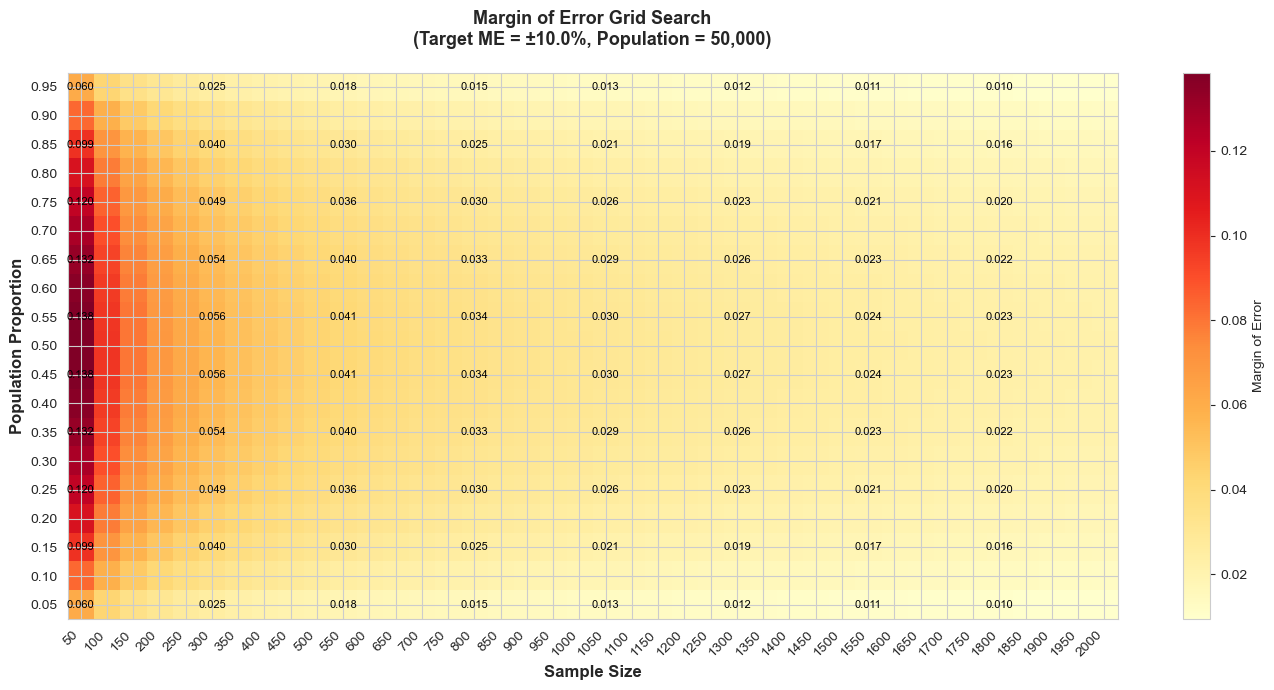

In [ ]:
def find_sample_sizes_for_precision(target_me, N, min_sample_size, max_sample_size, num_sample_steps,
                                     min_proportion, max_proportion, num_proportion_steps):
    """
    Find sample size combinations that achieve a target margin of error.
    
    Performs a grid search across all combinations of sample sizes and population 
    proportions, calculating the achieved margin of error for each. Returns both 
    a heatmap visualization and a table of combinations that meet the target.
    
    Parameters:
    -----------
    target_me : float
        Target margin of error (e.g., 0.10 for ±10%)
    N : int
        Total population size
    min_sample_size : int
        Minimum sample size to test
    max_sample_size : int
        Maximum sample size to test
    num_sample_steps : int
        Number of steps to divide the sample size range into
    min_proportion : float
        Minimum population proportion to test (e.g., 0.05 for 5%)
    max_proportion : float
        Maximum population proportion to test (e.g., 0.95 for 95%)
    num_proportion_steps : int
        Number of steps to divide the proportion range into
    
    Returns:
    --------
    tuple of (fig, analysis_df) where:
        - fig: matplotlib Figure object with heatmap
        - analysis_df: DataFrame of combinations achieving target ±10% tolerance
    """
    
    # Generate ranges based on number of steps
    sample_sizes = np.linspace(min_sample_size, max_sample_size, num_sample_steps, dtype=int)
    proportions = np.linspace(min_proportion, max_proportion, num_proportion_steps)
    
    # Grid search: calculate margin of error for all combinations
    results = []
    me_matrix = np.zeros((len(proportions), len(sample_sizes)))
    
    for i, p in enumerate(proportions):
        for j, n in enumerate(sample_sizes):
            result = confidence_interval_for_proportion(n, p, N)
            me = result['margin_of_error']
            me_matrix[i, j] = me
            
            results.append({
                'sample_size': n,
                'population_proportion': p,
                'margin_of_error': me
            })
    
    df_results = pd.DataFrame(results)
    
    # Find combinations close to target (within ±10% of target)
    tolerance = target_me * 0.10
    close_combos = df_results[
        (df_results['margin_of_error'] >= target_me - tolerance) &
        (df_results['margin_of_error'] <= target_me + tolerance)
    ].copy()
    
    # Sort by how close they are to target
    close_combos['distance_from_target'] = abs(close_combos['margin_of_error'] - target_me)
    close_combos = close_combos.sort_values('distance_from_target')
    
    # Create heatmap visualization
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Use a soft color palette (YlOrRd = Yellow-Orange-Red)
    im = ax.imshow(me_matrix, cmap='YlOrRd', aspect='auto', origin='lower')
    
    # Set axis labels
    ax.set_xticks(np.arange(len(sample_sizes)))
    ax.set_yticks(np.arange(len(proportions)))
    ax.set_xticklabels([f'{int(n)}' for n in sample_sizes], rotation=45, ha='right')
    ax.set_yticklabels([f'{p:.2f}' for p in proportions])
    
    ax.set_xlabel('Sample Size', fontsize=12, fontweight='bold')
    ax.set_ylabel('Population Proportion', fontsize=12, fontweight='bold')
    ax.set_title(
        f'Margin of Error Grid Search\n(Target ME = ±{target_me*100:.1f}%, Population = {N:,})',
        fontsize=13, fontweight='bold',
        pad=20
    )
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, label='Margin of Error')
    
    # Add text annotations for a subset (to avoid clutter)
    sample_step = max(1, len(sample_sizes) // 8)
    prop_step = max(1, len(proportions) // 8)
    
    for i in range(0, len(proportions), prop_step):
        for j in range(0, len(sample_sizes), sample_step):
            text = ax.text(j, i, f'{me_matrix[i, j]:.3f}',
                          ha="center", va="center", color="black", fontsize=8)
    
    plt.tight_layout()
    
    # Print analysis
    print("=" * 100)
    print(f"PRECISION ANALYSIS: Finding combinations for Target ME = ±{target_me*100:.1f}%")
    print(f"Population Size: {N:,}")
    print(f"Tolerance Range: ±{target_me*100:.1f}% ± 10% = [±{(target_me - tolerance)*100:.2f}%, ±{(target_me + tolerance)*100:.2f}%]")
    print("=" * 100)
    
    if len(close_combos) > 0:
        print(f"\n✓ Found {len(close_combos)} combinations within tolerance:\n")
        
        # Show top 15 closest matches
        display_df = close_combos.head(15)[['sample_size', 'population_proportion', 'margin_of_error']].copy()
        display_df['sample_size'] = display_df['sample_size'].astype(int)
        display_df['population_proportion'] = display_df['population_proportion'].apply(lambda x: f'{x:.2f}')
        display_df['margin_of_error'] = display_df['margin_of_error'].apply(lambda x: f'±{x*100:.3f}%')
        display_df.columns = ['Sample Size', 'Population Proportion', 'Achieved ME']
        display_df = display_df.reset_index(drop=True)
        
        print(display_df.to_string())
        print(f"\n(Showing top 15 of {len(close_combos)} matches)\n")
    else:
        print(f"\n✗ No combinations found within tolerance.")
        print(f"  Closest achieved margins of error:")
        # Calculate distance for all results
        df_results['distance_from_target'] = abs(df_results['margin_of_error'] - target_me)
        closest = df_results.nsmallest(5, 'distance_from_target')
        print(closest[['sample_size', 'population_proportion', 'margin_of_error']])
    
    print("=" * 100)
    
    return fig, close_combos


# Example usage
print("\nGenerating grid search...\n")

# Define search parameters
target_margin_error = 0.10  # Target: ±10%
population = 50000

# Run the grid search with min/max ranges
fig, matching_combinations = find_sample_sizes_for_precision(
    target_me=target_margin_error,
    N=population,
    min_sample_size=50,
    max_sample_size=2000,
    num_sample_steps=20,
    min_proportion=0.05,
    max_proportion=0.95,
    num_proportion_steps=19
)


plt.show()

PRECISION ANALYSIS: Finding combinations for Target ME = ±20.0%
Population Size: 4,000
Tolerance Range: ±20.0% ± 10% = [±18.00%, ±22.00%]

✗ No combinations found within tolerance.
  Closest achieved margins of error:
      sample_size  population_proportion  margin_of_error
4525          200                   0.30         0.061910
4344          200                   0.29         0.061302
4163          200                   0.28         0.060659
4526          210                   0.30         0.060338
3982          200                   0.27         0.059978


(<Figure size 1400x700 with 2 Axes>,
 Empty DataFrame
 Columns: [sample_size, population_proportion, margin_of_error, distance_from_target]
 Index: [])

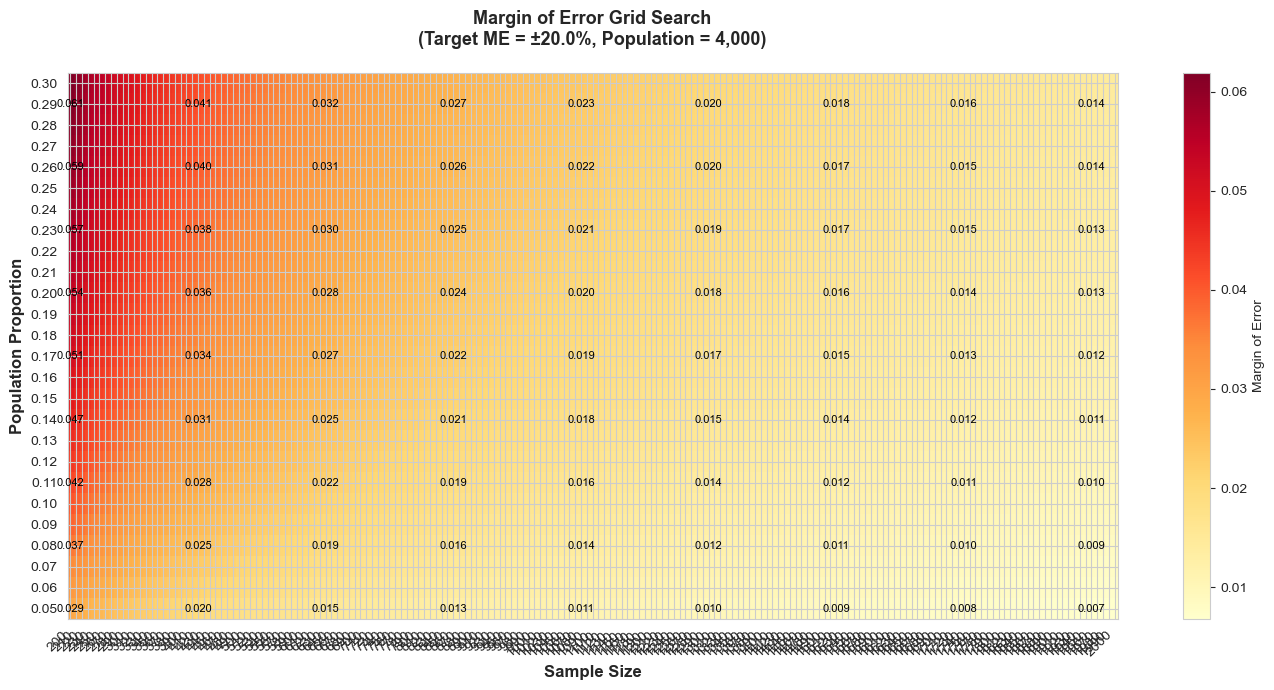

In [ ]:
# try it out

find_sample_sizes_for_precision(
    target_me = .20, 
    N = 4000, 
    min_sample_size = 200, 
    max_sample_size = 2000, 
    num_sample_steps = 10,
    min_proportion = .05, 
    max_proportion = .30, 
    num_proportion_steps = 6)